<a href="https://colab.research.google.com/github/Kishan459/NYC-Taxi-Trip-Time_prediction/blob/main/NYC_Taxi_Trip_Time_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

#### importing libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
import statsmodels.formula.api as sm
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import warnings; warnings.simplefilter('ignore')


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# import Dataset
df = pd.read_csv('/content/drive/MyDrive/Datasets/NYC Taxi Data (1).csv')

In [4]:
# checking the shape of data
df.shape

(1458644, 11)

In [5]:
# checking for null values
df.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

##### There are no nan/null record in dataset. so we don't have to impute any record.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


#### pickup_datetime,drpoff_datetime are object datatype we have to covert them into datetime format.

In [7]:
# converting timestamp to datatime format
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 122.4+ MB


In [9]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [10]:
# extracting hour,month,weekday,weekday_number from datatime feature
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['pickup_month'] = df['pickup_datetime'].dt.month
df['weekday_num'] = df['pickup_datetime'].dt.dayofweek
df['weekday_day'] = df['pickup_datetime'].dt.day_name()

In [11]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_hour,pickup_month,weekday_num,weekday_day
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,17,3,0,Monday
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,0,6,6,Sunday
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,11,1,1,Tuesday
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,19,4,2,Wednesday
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,13,3,5,Saturday


In [12]:
!pip install haversine

In [13]:
import haversine as hs

In [14]:
# function for calculating distance
def calculate_distance(df):
  pickup = (df['pickup_latitude'],df['pickup_longitude'])
  drop = (df['dropoff_latitude'],df['dropoff_longitude'])
  return hs.haversine(pickup,drop)

In [15]:
# calculating distance 
df['distance'] = df.apply(lambda x : calculate_distance(x),axis=1)

In [16]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_hour,pickup_month,weekday_num,weekday_day,distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,17,3,0,Monday,1.498523
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,0,6,6,Sunday,1.805510
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,11,1,1,Tuesday,6.385107
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,19,4,2,Wednesday,1.485500
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,13,3,5,Saturday,1.188590


#Univeriate Analysis

##Vendor ID

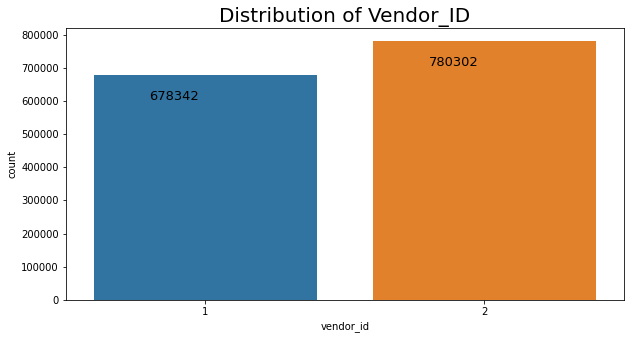

In [17]:
# finding which vender have large market share
plt.figure(figsize=(10,5))
ax = sns.countplot(df['vendor_id'])
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), va='top', color='black', size=13)
plt.title('Distribution of Vendor_ID',fontsize=20)
plt.show()

#### vender with id 2 has large market share than vender with id 1

##Store_and_fwd_flag

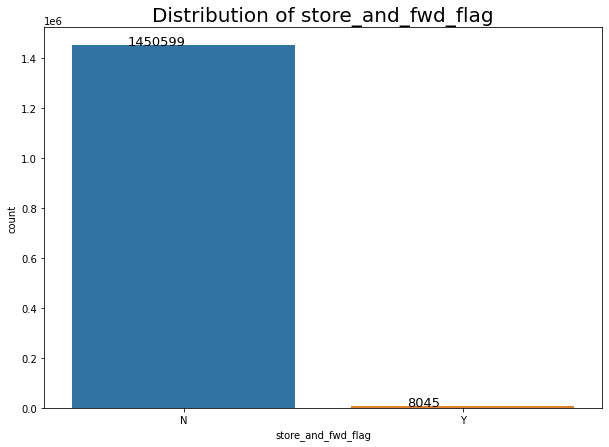

In [18]:
# finding frequency of trip according to trip record was held in vehicle or not 
plt.figure(figsize=(10,7))
ax = sns.countplot(df['store_and_fwd_flag'])
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), color='black', size=13)
plt.title('Distribution of store_and_fwd_flag',fontsize=20)
plt.show()

In [19]:
round(df['store_and_fwd_flag'].value_counts(normalize=True),2)

N    0.99
Y    0.01
Name: store_and_fwd_flag, dtype: float64

#### Above result shows that only about 1% of the trip details were stored in the vehicle first before sending it to the server.

##PickUp Hour

Text(0.5, 1.0, 'Distribution of pickup_hour')

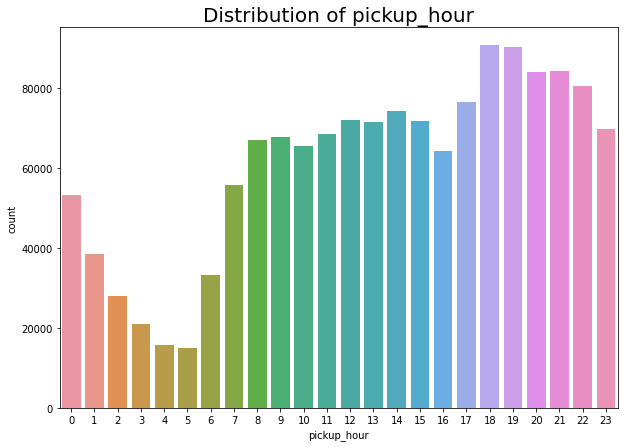

In [20]:
# visualization of frequency of trip according to pick_hour
plt.figure(figsize=(10,7))
sns.countplot(df['pickup_hour'])
plt.title('Distribution of pickup_hour',fontsize=20)

#### pickup hour is on its peak at 18 to 22 hour (evening) ,followed by 12 to 15 (Afternoon).
#### and pickup hour is on its lowest at 4 to 5 hour (early morning).

In [21]:
# frequency of trip according to pick_hour
df['pickup_hour'].value_counts()

18    90600
19    90308
21    84185
20    84072
22    80492
17    76483
14    74292
12    71873
15    71811
13    71473
23    69785
11    68476
9     67663
8     67053
10    65437
16    64313
7     55600
0     53248
1     38571
6     33248
2     27972
3     20895
4     15792
5     15002
Name: pickup_hour, dtype: int64

##PickUP Month

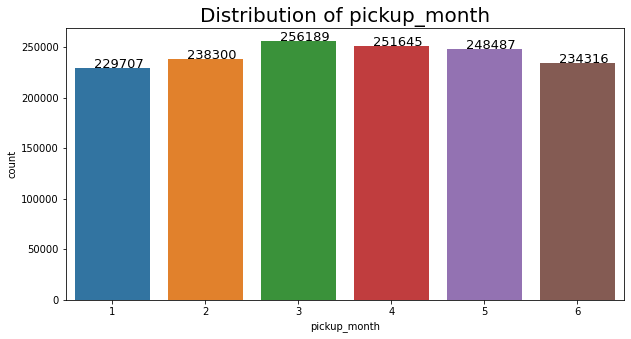

In [22]:
# visualization of frequency of trip according to month
plt.figure(figsize=(10,5))
ax = sns.countplot(df['pickup_month'])
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), color='black', size=13)
plt.title('Distribution of pickup_month',fontsize=20)
plt.show()

####dropoff_datetime has a extra month compared to pickup_datetime column with only 127 observatons when dropoff_datetime month is 7 , this is becuase people have taken ride at late night of last date of 6th month.

#### Trip accross the month is nearly balanced

##WeekDays

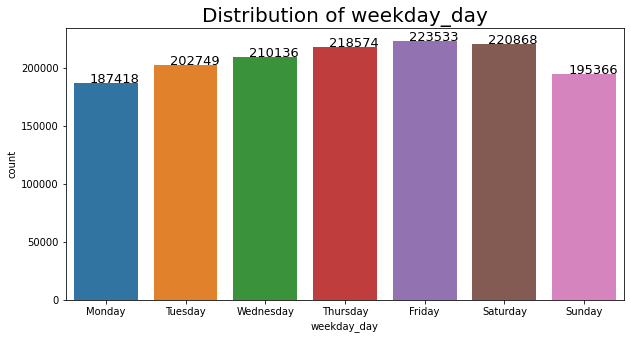

In [23]:
# visualization of trip frequancy according to weekday
plt.figure(figsize=(10,5))
ax = sns.countplot(df['weekday_day'],order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday","Sunday"])
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), color='black', size=13)
plt.title('Distribution of weekday_day',fontsize=20)
plt.show()

#####Here we can see an increasing trend of taxi pickups starting from Monday till Friday. The trend starts declining from saturday till monday which is normal where some office going people likes to stay at home for rest on the weekends.

In [24]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_hour,pickup_month,weekday_num,weekday_day,distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,17,3,0,Monday,1.498523
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,0,6,6,Sunday,1.805510
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,11,1,1,Tuesday,6.385107
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,19,4,2,Wednesday,1.485500
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,13,3,5,Saturday,1.188590


##Passanger Count

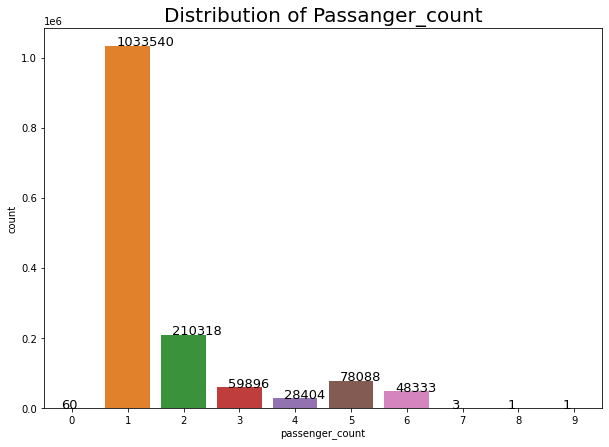

In [25]:
# finding frequency of trip according to number of passanger.
plt.figure(figsize=(10,7))
ax = sns.countplot(df['passenger_count'])
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), color='black', size=13)
plt.title('Distribution of Passanger_count',fontsize=20)
plt.show()

#### most of the trip is taken by the single passanger and there are very fewer no. of trip is taken by more then 6 passengers and they might be outliers because fitting more then is not possible. 6 people is possible which contain 1 child and driver. 0 is outlier too.

In [26]:
# frequency of trips count according to passanger count
df['passenger_count'].value_counts()

1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: passenger_count, dtype: int64

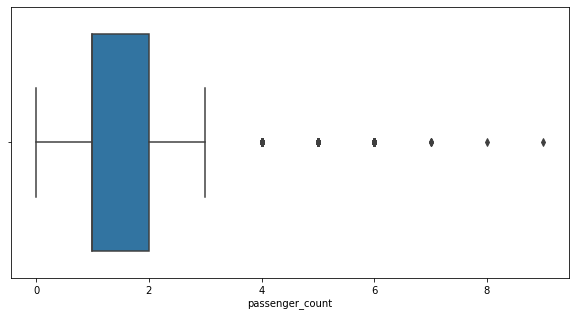

In [27]:
# boxplot of passanger count
plt.figure(figsize=(10,5))
sns.boxplot(df['passenger_count'])

#### there are some trips with 0 passanger count.
#### few trips consist of 7,8,9 passanger , they are outliers
#### most of the trips consist of 1 or 2 passangers.

In [28]:
# summary statistics of passanger count
df.passenger_count.describe().astype('int')

count    1458644
mean           1
std            1
min            0
25%            1
50%            1
75%            2
max            9
Name: passenger_count, dtype: int64

#### Mean,Median and mode are same.
#### passanger count has standard deviation of 1.
#### Minimum passanger count is 0.Since trips not possible without customers we will remove this.
#### Max passanger count is 9 which is clearly outlier we will remove it too.

In [29]:
# removing the outliers from passanger count
df = df[df.passenger_count > 0]
df = df[df.passenger_count <= 6]

#### Acoording to www1.nyc.gov The maximum amount of passengers allowed in a yellow taxicab by law is four (4) in a four (4) passenger taxicab or five (5) passengers in a five (5) passenger taxicab, except that an additional passenger must be accepted if such passenger is under the age of seven (7) and is held on the lap of an adult passenger seated in the rear.
#### So, in total we can assume that maximum 6 passenger can board the new york taxi i.e. 5 adult + 1 minor
#### Since trips not possible without customers thats why I removed trips with 0 passangers and more than 6 passanger can't sit in a taxi thats why I removed more trips with more than 6 passangers(they are outliers)

In [30]:
# frequency of trips count according to passanger count after removing outliers
df.passenger_count.value_counts()

1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
Name: passenger_count, dtype: int64

In [31]:
df.shape

(1458579, 16)

#### After removing Outliers from passanger count we are left with 1458579 observations.

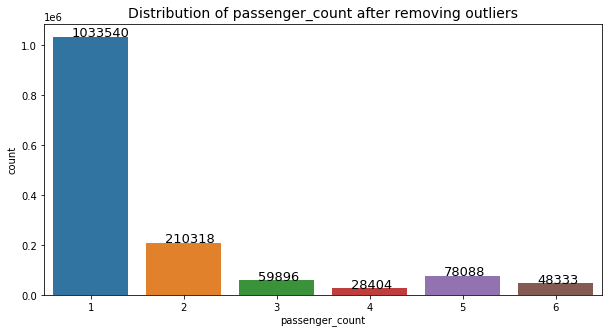

In [32]:
# visualization of passanger count after removing outliers 
plt.figure(figsize=(10,5))
ax = sns.countplot(df.passenger_count)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), color='black', size=13)
plt.title('Distribution of passenger_count after removing outliers',fontsize=14)
plt.show()

##Distance

In [33]:
# summary statistics of Distance
round(df['distance'].describe(),2)

count    1458579.00
mean           3.44
std            4.30
min            0.00
25%            1.23
50%            2.09
75%            3.88
max         1240.91
Name: distance, dtype: float64

#### Distances are in Kilometers
#### some trips with 0 km
#### some trips are over 100km
#### Mean distane is approx 3.5 km and standard deviation is 4.3 km which means most of the trips are in range of 1 to 10 km

In [34]:
df['distance'].unique().shape

(1452234,)

In [35]:
df[df['distance']==0].shape

(5887, 16)

#### There are 5887 trips whith 0 distance.

#####Customer might have changed thier mind and cancelled the journey just after accepting it.
#####Driver might have cancelled the trip just after accepting it due to some reason. So the trip couldn't start.


In [36]:
# finding no. of observations with more than 100km
df[df['distance']>=100].shape

(19, 16)

#### There are only 19 trips more than 100 km 

In [37]:
# finding no. of trips with more than 10km
df[df['distance']>10].shape

(89133, 16)

#### There are 89133 trips with more than 10 km 

In [38]:
# finding no. of trips with more than 0 km and less than and equal to 10 km
df[(df['distance']<=10) & (df['distance']>0)].shape

(1363559, 16)

#### There are 1363559 trips in range of 1 to 10 km 

In [39]:
# finding no. of trips with more than 0 km and less than and equal to 30 km
df[(df['distance']<=30) & (df['distance']>0)].shape

(1452119, 16)

#### we have to predict the trip duration inside New York Ciy.
#### The radius of New York City is 30 km approx. So we are going to treat Trips with Distance more than 30 km as outliers.

In [40]:
# removed outliers from distance
df = df[(df['distance']>0) & (df['distance']<=30)]

In [41]:
df.shape

(1452119, 16)

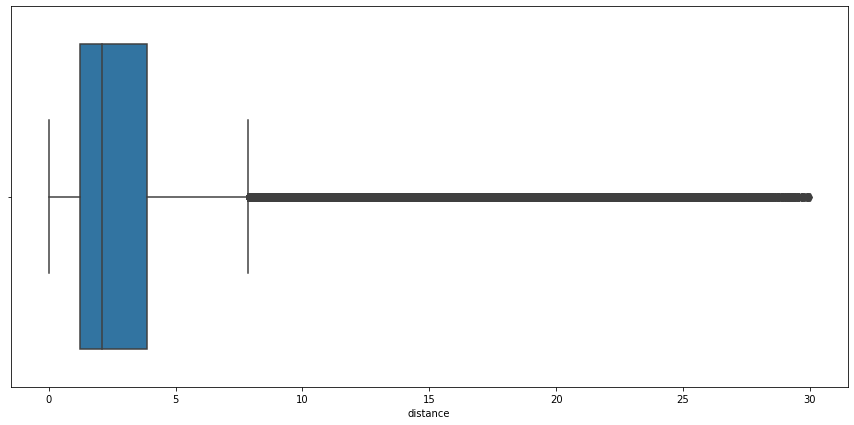

In [42]:
# ploting distance's boxplot
plt.figure(figsize=(15,7))
sns.boxplot(df['distance'])

##Trip Duration

In [43]:
# summary statistics of Trip Duration
df['trip_duration'].describe().astype('int')

count    1452119
mean         960
std         5245
min            1
25%          398
50%          663
75%         1076
max      3526282
Name: trip_duration, dtype: int64

#### In summary statistics of trip Duration we can see that Mean trip Duration is 960 seconds. Standard deviation is 5245 seconds. upto 75% trip's duration is less than 1076 seconds.Minumun duration is 1 second and Max duration is 3526282 seconds (40 days approx) which means there are outliers. 

#### we will remove outliers after comparing distance with trip duration at the time of doing Bivariate Analysis.

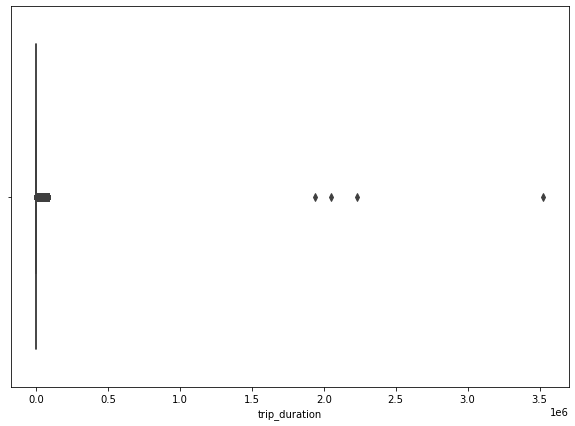

In [44]:
# boxplot of trip duration
plt.figure(figsize=(10,7))
sns.boxplot(df['trip_duration'])

In [45]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_hour,pickup_month,weekday_num,weekday_day,distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,17,3,0,Monday,1.498523
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,0,6,6,Sunday,1.805510
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,11,1,1,Tuesday,6.385107
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,19,4,2,Wednesday,1.485500
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,13,3,5,Saturday,1.188590


#Bivariate Analysis

##Trip Duration Vs Vendor

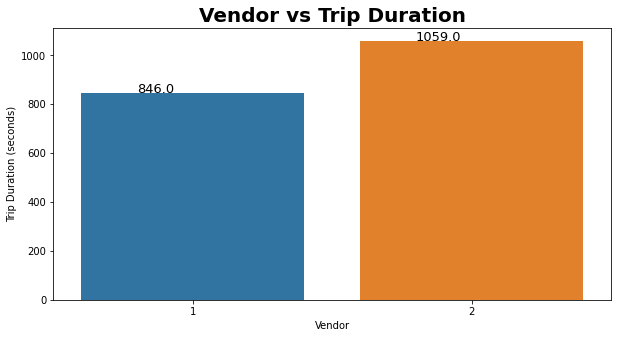

In [46]:
# visualization of vendor id and avarage trip duration
plt.figure(figsize=(10,5))
vendor_id_trip_d = round(df.groupby('vendor_id')['trip_duration'].mean(),0)
ax = sns.barplot(vendor_id_trip_d.index,vendor_id_trip_d.values)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), color='black', size=13)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Vendor')
plt.title('Vendor vs Trip Duration',fontsize=20,weight='bold')
plt.show()

#### Average trip diration of Vendor 2 is higher than Vendor 1 by 200 seconds approx

## Trip Duration Vs Passanger Count

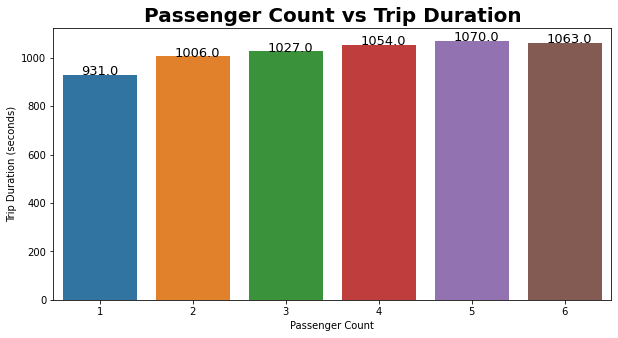

In [47]:
# visualization of Passanger Count and avarage trip duration
passanger_Count_vs_trip_d = round(df.groupby('passenger_count')['trip_duration'].mean(),0)
plt.figure(figsize=(10,5))
ax = sns.barplot(passanger_Count_vs_trip_d.index,passanger_Count_vs_trip_d.values)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), color='black', size=13)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Passenger Count')
plt.title('Passenger Count vs Trip Duration',fontsize=20,weight='bold')
plt.show()

#### Trip duration for all the passanger counts are aprrox similar. except passanger count 1( average trip duratuion of passanger count 1 is lower than others).

##Trip Duration Vs PickUp_Hour

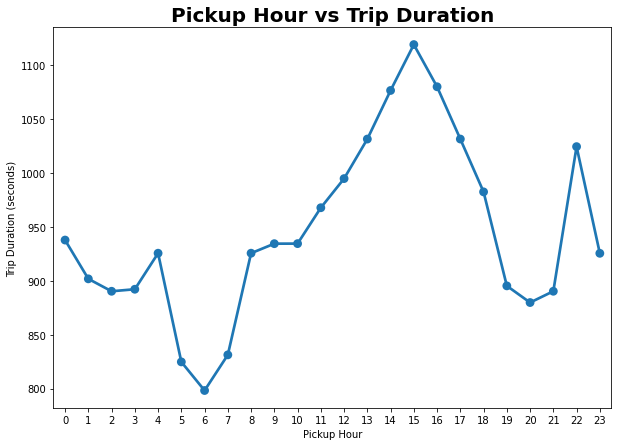

In [48]:
# visualization of PickUp Hour and avarage trip duration
td_ph = df.groupby('pickup_hour')['trip_duration'].mean()
plt.figure(figsize=(10,7))
sns.pointplot(td_ph.index,td_ph.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Pickup Hour')
plt.title('Pickup Hour vs Trip Duration',fontsize=20,weight='bold')
plt.show()

#### Average trip duration is lower at 6am in the morning due to minimaln traffic on the road. and higher at 15 hour(3pm) because streets are bust at this time.

## Trip Duration vs PickUp Month

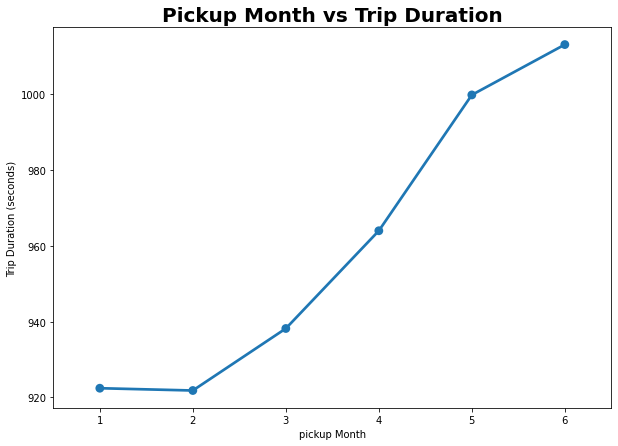

In [49]:
# visualization of PickUp Month and avarage trip duration
td_pm = df.groupby('pickup_month')['trip_duration'].mean()
plt.figure(figsize=(10,7))
sns.pointplot(td_pm.index,td_pm.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('pickup Month')
plt.title('Pickup Month vs Trip Duration',fontsize=20,weight='bold')
plt.show()

#### Avarage Trip duration is increasing along with each subsequent month.
#### we can see that at the time of winter jan and feb trip duration is less may be due to less traffic in winters but as summer approches the trip duration is started increasing.

##Trip Duration vs WeekDays

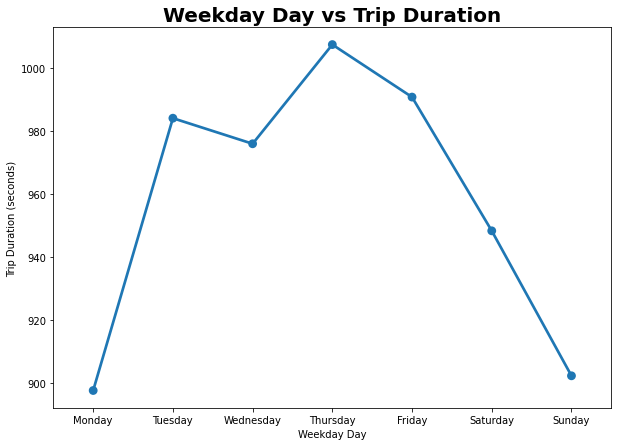

In [50]:
# visualization of weekdays and avarage trip duration
td_pwd = df.groupby('weekday_day')['trip_duration'].mean()
plt.figure(figsize=(10,7))
sns.pointplot(td_pwd.index,td_pwd.values,order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday","Sunday"])
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Weekday Day')
plt.title('Weekday Day vs Trip Duration',fontsize=20,weight='bold')
plt.show()

#### we can see that avarage trip duration is alomst same and lowest on monday and sunday.
#### Avarage trip duration is highest on thrusday.